# Implementation of HWP demodulation 

This notebook tries to implement demodulation process into a simulation of a ground experiment with rotating HWP.

In [1]:
import os
import sys

import healpy as hp
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import toast
import toast.pipeline_tools
from toast.mpi import MPI


# Are you using a special reservation for a workshop?
# If so, set it here:
nersc_reservation = None

# Load common tools for all lessons
import sys
sys.path.insert(0, "../lessons")
from lesson_tools import (
    check_nersc,
    fake_focalplane
)
nersc_host, nersc_repo, nersc_resv = check_nersc(reservation=nersc_reservation)

# Capture C++ output in the jupyter cells
%reload_ext wurlitzer

! [ ! -e weather_Atacama.fits ] && wget http://portal.nersc.gov/project/cmb/toast_data/example_data/weather_Atacama.fits

Not running at NERSC, slurm jobs disabled.


## Parameters

These arguments control the entire notebook

In [2]:
class args:
    split_schedule = None
    schedule = "schedule.txt"
    sort_schedule = False  # Matters for parallelization
    weather = "weather_Atacama.fits"
    sample_rate = 10  # Hz
    # Noise parameters
    fknee = 1.0
    alpha = 2.0
    # Scanning parameters
    scan_rate = 1.0  # deg / s
    scan_accel = 1.0  # deg / s^2
    # half-wave plate
    hwp_rpm = None
    hwp_step_deg = None
    hwp_step_time_s = None
    fov = 3.0  # Field-of-view in degrees
    # Projection parameters
    coord = "C"
    nside = 64
    mode = "IQU"
    outdir = "maps"

Set hwp_rpm as same as science band

In [3]:
beam_size = hp.nside2resol(args.nside, arcmin=True) / 60.
science_band_width = args.scan_rate / beam_size / 2
assert science_band_width * 5 < args.sample_rate
args.hwp_rpm = science_band_width * 60
print('beam_size: {:.2f} deg'.format(beam_size))
print('science band: {:.2f} Hz'.format(science_band_width))
print('hwp_rpm: {:1.0f} RPM'.format(args.hwp_rpm))

beam_size: 0.92 deg
science band: 0.55 Hz
hwp_rpm: 33 RPM


## Observing schedule

We write the scheduler parameters to file.  These arguments produce one constant elevation scan but you can easily modify that.

In [4]:
%%writefile schedule.par
--site-lat
-22.958064
--site-lon
-67.786222
--site-alt
5200
--site-name
Atacama
--telescope
LAT
--start
2020-01-01 00:00:00
--stop
2020-01-02 00:00:00
--patch-coord
C
--patch
small_patch,1,40,-40,10
--ces-max-time
86400
--out
schedule.txt

Overwriting schedule.par


Now run the scheduler.  The observing schedule will end up in `schedule.txt`.

In [5]:
! toast_ground_schedule.py @schedule.par

TOAST INFO: Adding patch "small_patch"
TOAST INFO: Center-and-width format
TOAST INFO: Global timer: toast_ground_schedule:  0.46 seconds (1 calls)


## Focalplane

In [6]:
focalplane = toast.pipeline_tools.Focalplane(
    fake_focalplane(fov=args.fov, fknee=args.fknee, alpha=args.alpha),
    sample_rate=args.sample_rate, 
)

## TODGround to `toast.data`

In [7]:
mpiworld, procs, rank = toast.mpi.get_world()
comm = toast.mpi.Comm(mpiworld)

# Load the observing schedule, append weather and focalplane to it
    
schedules = toast.pipeline_tools.load_schedule(args, comm)
toast.pipeline_tools.load_weather(args, comm, schedules)
# There could be more than one observing schedule, but not this time
schedule = schedules[0]
schedule.telescope.focalplane = focalplane

# Useful shorthands in what follows
telescope = schedule.telescope
site = telescope.site

# Create TODGround objects based on the entries in the schedule
    
data = toast.Data(comm)

for ces in schedule.ceslist:
    totsamples = int((ces.stop_time - ces.start_time) * args.sample_rate)

    tod = toast.todmap.TODGround(
        comm.comm_group,
        focalplane.detquats,
        totsamples,
        detranks=(1 if comm.comm_group is None else comm.comm_group.size),
        firsttime=ces.start_time,
        rate=args.sample_rate,
        site_lon=site.lon,
        site_lat=site.lat,
        site_alt=site.alt,
        azmin=ces.azmin,
        azmax=ces.azmax,
        el=ces.el,
        scanrate=args.scan_rate,
        scan_accel=args.scan_accel,
        coord=args.coord,
        hwprpm=args.hwp_rpm,
        hwpstep=args.hwp_step_deg,
        hwpsteptime=args.hwp_step_time_s,
    )

    # Now embed the TOD in an observation dictionary and add other necessary metadata

    obs = {}
    obs["name"] = "CES-{}-{}-{}-{}-{}".format(
        site.name, telescope.name, ces.name, ces.scan, ces.subscan
    )
    obs["tod"] = tod
    obs["noise"] = focalplane.noise
    obs["id"] = int(ces.mjdstart * 10000)
    obs["intervals"] = tod.subscans
    obs["site"] = site
    obs["site_name"] = site.name
    obs["site_id"] = site.id
    obs["altitude"] = site.alt
    obs["weather"] = site.weather
    obs["telescope"] = telescope
    obs["telescope_name"] = telescope.name
    obs["telescope_id"] = telescope.id
    obs["focalplane"] = focalplane.detector_data
    obs["fpradius"] = focalplane.radius
    obs["start_time"] = ces.start_time
    obs["season"] = ces.season
    obs["date"] = ces.start_date
    obs["MJD"] = ces.mjdstart
    obs["rising"] = ces.rising
    obs["mindist_sun"] = ces.mindist_sun
    obs["mindist_moon"] = ces.mindist_moon
    obs["el_sun"] = ces.el_sun
    
    # And append the observation to the list of observations
    
    data.obs.append(obs)

TOAST INFO: Load 8 (sub)scans in schedule.txt:  0.02 seconds (1 calls)
TOAST INFO: Loading schedule(s):  0.02 seconds (1 calls)
TOAST INFO: Load weather_Atacama.fits:  1.49 seconds (1 calls)
TOAST INFO: TODGround: simulate scan:  0.02 seconds (1 calls)
TOAST INFO: TODGround: list valid intervals:  0.00 seconds (1 calls)
TOAST INFO: TODGround: call base class constructor:  0.00 seconds (1 calls)
TOAST INFO: TODGround: translate scan pointing:  0.09 seconds (1 calls)
TOAST INFO: TODGround: simulate scan:  0.01 seconds (1 calls)
TOAST INFO: TODGround: list valid intervals:  0.00 seconds (1 calls)
TOAST INFO: TODGround: call base class constructor:  0.00 seconds (1 calls)
TOAST INFO: TODGround: translate scan pointing:  0.04 seconds (1 calls)
TOAST INFO: TODGround: simulate scan:  0.01 seconds (1 calls)
TOAST INFO: TODGround: list valid intervals:  0.00 seconds (1 calls)
TOAST INFO: TODGround: call base class constructor:  0.00 seconds (1 calls)
TOAST INFO: TODGround: translate scan pointi

## Pointing matrix

Here we translate the boresight quaternions into detector pointing (pixels numbers and Stokes weights).

In [8]:
toast.todmap.OpPointingHpix(nside=args.nside, nest=True, mode=args.mode).exec(data)
#weights_name = 'weights'
#weights_rot_name = 'weights_rot'
#weights_stop_name = 'weights_stop'
#toast.tod.OpCacheCopy(input=weights_name, output=weights_rot_name, force=True).exec(data)

## Sky signal

Create a synthetic Gaussian map to scan as input signal

Constant Q polarization is added to make modulation clear.

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


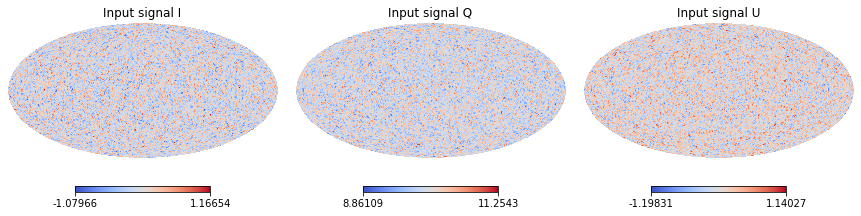

In [9]:
lmax = args.nside * 2
cls = np.zeros([4, lmax + 1])
cls[:3] = 1./lmax**2
sim_map = hp.synfast(cls, args.nside, lmax=lmax, new=True)
sim_map[1]+=10 # Constant Q polarization

plt.figure(figsize=[12, 8])
for i, m in enumerate(sim_map):
    hp.mollview(sim_map[i], cmap="coolwarm", title="Input signal {}".format("IQU"[i]), sub=[1, 3, 1+i])
hp.write_map("sim_map.fits", hp.reorder(sim_map, r2n=True), nest=True, overwrite=True)

Scan the sky signal

In [10]:
full_name = "signal"
sky_name = "sky_signal"

# Clear any lingering sky signal from the buffers
class OpClearDemodulated(toast.Operator):
    '''Reset data after demodulation'''
    def exec(self, data):
        removed_keys = set()
        for obs in data.obs:
            tod = obs['tod']
            for key in tod.cache.keys():
                if 'demod' in key:
                    tod.cache.destroy(key)
                    removed_keys.add(key)
            if hasattr(tod, '_dist_dets_copy'):
                tod._dist_dets = tod._dist_dets_copy
                del(tod._dist_dets_copy)
            noise = obs['noise']
            for noiseprop in vars(noise).values():
                if not hasattr(noiseprop, 'keys'):
                    continue
                for key in list(noiseprop.keys()):
                    if key.startswith('demod'):
                        noiseprop.pop(key)
        if removed_keys:
            print('Removed:', removed_keys)

OpClearDemodulated().exec(data)
toast.tod.OpCacheClear(full_name).exec(data)



distmap = toast.map.DistPixels(
    data,
    nnz=len(args.mode),
    dtype=np.float32,
)
distmap.read_healpix_fits("sim_map.fits")
toast.todmap.OpSimScan(distmap=distmap, out=full_name).exec(data)

# Copy the sky signal, just in case we need it later

toast.tod.OpCacheCopy(input=full_name, output=sky_name, force=True).exec(data)

## Noise

Simulate noise and make a copy of signal+noise in case we need it later

In [11]:
copy_name = "signal_copy"

toast.tod.OpSimNoise(out=full_name, realization=0).exec(data)

toast.tod.OpCacheCopy(input=full_name, output=copy_name, force=True).exec(data)

## Your own operator here

Here we define an empty operator you can work with

In [12]:
import scipy.signal

class MyOperator(toast.Operator):
    def __init__(self, name="signal", numtaps=None, fmax=None):
        """ Arguments:
        name(str) : Cache prefix to operate on
        fmax(float) : max frequency of low-pass filter 
        numtaps(int) : kernel size of filters
        """
        self._name = name
        self._numtaps = numtaps
        self._fmax = fmax
    
    def exec(self, data):
        # We loop here over all local data but do nothing with it.
        for obs in data.obs:
            tod = obs["tod"]
            hwp_angle = tod.local_hwp_angle()
            if self._fmax is not None:
                fmax = self._fmax
            else:
                # set low-pass filter cut-off frequency as same as HWP 1f
                hwp_speed = (np.unwrap(hwp_angle)[-1] - hwp_angle[0]) / (hwp_angle.size - 1) * tod._rate / (np.pi * 2)
                fmax = hwp_speed
                print('fmax', fmax)
            if self._numtaps is not None:
                numtaps = self._numtaps
            else:
                # set kernel size longer than low-pass filter time scale
                numtaps = (1 << int(np.ceil(np.log(tod._rate / fmax * 10) / np.log(2)))) - 1
                print('numtaps', numtaps)
            # kernel for low-pass filter
            lpf = scipy.signal.firwin(numtaps, [fmax], fs=tod._rate, pass_zero=True)
            cos_4hwp_angle = np.cos(4 * hwp_angle)
            sin_4hwp_angle = np.sin(4 * hwp_angle)

            for det in tod.local_dets:
                if det.startswith('demod'):
                    continue

                # flag invalid sample in both edge
                flag = tod.local_flags(det)
                flag[:numtaps//2] = False
                flag[-(numtaps//2):] = False

                # demodulate signal TOD
                signal = tod.local_signal(det, self._name)
                signal_demod0 = scipy.signal.fftconvolve((signal), lpf, mode='same').real
                signal_demod4r = scipy.signal.fftconvolve((signal * cos_4hwp_angle * 2), lpf, mode='same').real
                signal_demod4i = scipy.signal.fftconvolve((signal * sin_4hwp_angle * 2), lpf, mode='same').real
                signal_name_0 = '{}_demod0_{}'.format(self._name, det)
                signal_name_4r = '{}_demod4r_{}'.format(self._name, det)
                signal_name_4i = '{}_demod4i_{}'.format(self._name, det)
                tod.cache.put(signal_name_0, signal_demod0, replace=True)
                tod.cache.put(signal_name_4r, signal_demod4r, replace=True)
                tod.cache.put(signal_name_4i, signal_demod4i, replace=True)
                del(signal_demod0, signal_demod4r, signal_demod4i)

                # demodulate pointing matrix
                weights = tod.cache.reference('weights_{}'.format(det))
                weights_demod0 = np.vstack([
                    scipy.signal.fftconvolve((weights[:,0]), lpf, mode='same').real,
                    scipy.signal.fftconvolve((weights[:,1]), lpf, mode='same').real,
                    scipy.signal.fftconvolve((weights[:,2]), lpf, mode='same').real]).T
                weights_name = 'weights_demod0_{}'.format(det)
                tod.cache.put(weights_name, weights_demod0, replace=True)
                del(weights_demod0)
                weights_demod4r = np.vstack([
                    scipy.signal.fftconvolve((weights[:,0] * cos_4hwp_angle * 2), lpf, mode='same').real,
                    scipy.signal.fftconvolve((weights[:,1] * cos_4hwp_angle * 2), lpf, mode='same').real,
                    scipy.signal.fftconvolve((weights[:,2] * cos_4hwp_angle * 2), lpf, mode='same').real]).T
                weights_name_4r = 'weights_demod4r_{}'.format(det)
                tod.cache.put(weights_name_4r, weights_demod4r, replace=True)
                del(weights_demod4r)
                weights_demod4i = np.vstack([
                    scipy.signal.fftconvolve((weights[:,0] * sin_4hwp_angle * 2), lpf, mode='same').real,
                    scipy.signal.fftconvolve((weights[:,1] * sin_4hwp_angle * 2), lpf, mode='same').real,
                    scipy.signal.fftconvolve((weights[:,2] * sin_4hwp_angle * 2), lpf, mode='same').real]).T
                weights_name_4i = 'weights_demod4i_{}'.format(det)
                tod.cache.put(weights_name_4i, weights_demod4i, replace=True)
                del(weights_demod4i)
                
                # copy pointing
                local_pixels = tod.cache.reference('pixels_{}'.format(det))
                for demodkey in ['demod0', 'demod4r', 'demod4i']:
                    demod_name = 'pixels_{}_{}'.format(demodkey, det)
                    tod.cache.put(demod_name, local_pixels, replace=True)
                
                # copy noise properties
                noise = obs['noise']
                for noiseprop in vars(noise).values():
                    if hasattr(noiseprop, 'keys') and det in noiseprop:
                        for demodkey in ['demod0', 'demod4r', 'demod4i']:
                            demod_name = '{}_{}'.format(demodkey, det)
                            noiseprop[demod_name] = noiseprop[det]

            # change detector list
            tod._dist_dets_copy = tod._dist_dets
            demod_dets = [['{}_{}'.format(demodkey, det) 
                           for det in localdet
                                if not det.startswith('demod')
                                   for demodkey in ['demod0', 'demod4r', 'demod4i']]
                          for localdet in tod._dist_dets]
            tod._dist_dets = demod_dets

Then we apply the operator to the data

In [13]:
#toast.tod.OpCacheCopy(input=weights_rot_name, output=weights_name, force=True).exec(data)
toast.tod.OpCacheCopy(input=copy_name, output=full_name, force=True).exec(data)
MyOperator(name=full_name).exec(data)
#toast.todmap.OpPointingHpix(nside=args.nside, nest=True, mode=args.mode).exec(data)
#OpCacheCopyNoDet(input=hwp_name, output=hwp_stop_name, force=True).exec(data)

fmax 0.5457742442329279
numtaps 255
fmax 0.5457742442303931
numtaps 255
fmax 0.5457742442299521
numtaps 255
fmax 0.5457742442299521
numtaps 255
fmax 0.5457742442299521
numtaps 255
fmax 0.5457742442299521
numtaps 255
fmax 0.5457742442301045
numtaps 255
fmax 0.5457742442310318
numtaps 255


Plot a short segment of the signal before and after the operator

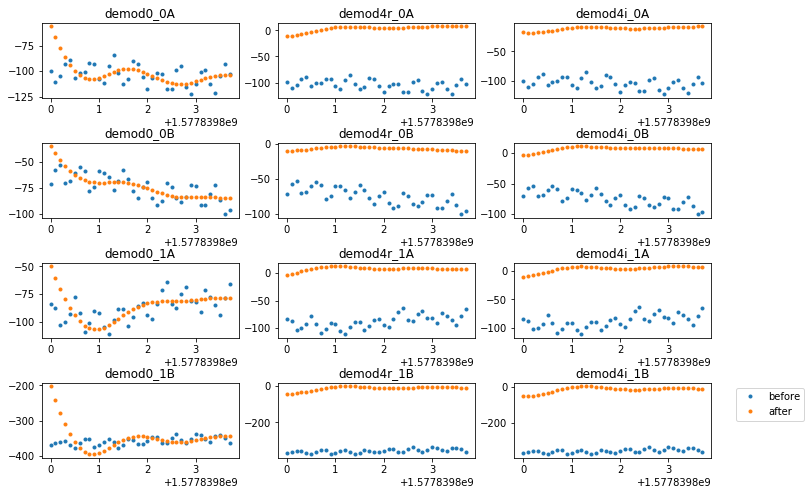

In [18]:
tod = data.obs[0]["tod"]
times = tod.local_times()

fig = plt.figure(figsize=[12, 8])
for idet, det in enumerate(tod.local_dets[:12]):
    cflags = tod.local_common_flags()
    before = tod.local_signal(det.split('_')[1], copy_name)
    after = tod.local_signal(det, full_name)
    
    ind = slice(0, 38)
    # Flag out turnarounds
    good = (cflags[ind] & tod.TURNAROUND) == 0
    ax = fig.add_subplot(4, 3, 1 + idet)
    ax.set_title(det)
    ax.plot(times[ind][good], before[ind][good], '.', label="before")
    ax.plot(times[ind][good], after[ind][good], '.', label="after")
ax.legend(bbox_to_anchor=(1.1, 1.00))
fig.subplots_adjust(hspace=0.6)

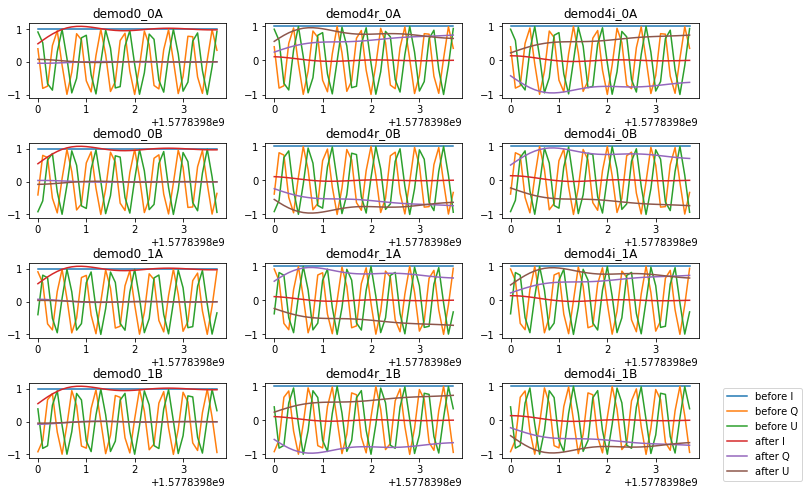

In [19]:
tod = data.obs[0]["tod"]
times = tod.local_times()

fig = plt.figure(figsize=[12, 8])
for idet, det in enumerate(tod.local_dets[:12]):
    cflags = tod.local_common_flags()
    weights_before = tod.cache.reference('weights_{}'.format(det.split('_')[-1]))
    weights_after = tod.cache.reference('weights_{}'.format(det))
    
    ind = slice(0, 38)
    # Flag out turnarounds
    good = (cflags[ind] & tod.TURNAROUND) == 0
    ax = fig.add_subplot(4, 3, 1 + idet)
    ax.set_title(det)
    for i in range(3):
        ax.plot(times[ind][good], weights_before[ind][good][:,i], '-', label="before "+('IQU'[i]))
    for i in range(3):
        ax.plot(times[ind][good], weights_after[ind][good][:,i], '-', label="after "+('IQU'[i]))
ax.legend(bbox_to_anchor=(1.1, 1.00))
fig.subplots_adjust(hspace=0.6)

## Make a map

Destripe the signal and make a map.  We use the nascent TOAST mapmaker because it can be run in serial mode without MPI.  The TOAST mapmaker is still significantly slower so production runs should used `libMadam`.

In [15]:
# Always begin mapmaking by copying the simulated signal.

destriped_name = "destriped"
#toast.tod.OpCacheCopy(input=copy_name, output=destriped_name, force=True).exec(data)
toast.tod.OpCacheCopy(input='signal', output=destriped_name, force=True).exec(data)
#toast.tod.OpCacheCopy(input='weights{}'.format(target_name), output='weights', force=True).exec(data)

mapmaker = toast.todmap.OpMapMaker(
    nside=args.nside,
    nnz=3,
    name=destriped_name,
    outdir=args.outdir,
    outprefix="toast_test_",
    baseline_length=10,
    iter_max=100,
    use_noise_prior=False,
)
mapmaker.exec(data)

TOAST INFO: Flag gaps:  0.02 seconds (1 calls)
TOAST INFO: Get detector weights:  0.05 seconds (1 calls)
TOAST INFO: Identify local submaps:  0.00 seconds (1 calls)
TOAST INFO: Accumulate N_pp'^1:  0.56 seconds (1 calls)
TOAST INFO: All reduce N_pp'^1:  0.02 seconds (1 calls)
TOAST INFO: Wrote hits to maps/toast_test_hits.fits
TOAST INFO: Write hits:  0.06 seconds (1 calls)
TOAST INFO: Wrote inverse white noise covariance to maps/toast_test_invnpp.fits
TOAST INFO: Write N_pp'^1:  0.07 seconds (1 calls)
TOAST INFO: Compute reciprocal condition numbers:  0.00 seconds (1 calls)
TOAST INFO: Wrote reciprocal condition numbers to maps/toast_test_rcond.fits
TOAST INFO: Write rcond:  0.03 seconds (1 calls)
TOAST INFO: Invert N_pp'^1:  0.00 seconds (1 calls)
TOAST INFO: Wrote white noise covariance to maps/toast_test_npp.fits
TOAST INFO: Write N_pp':  0.05 seconds (1 calls)
TOAST INFO:   Build noise-weighted map:  0.00 seconds (0 calls)
TOAST INFO:   Apply noise covariance:  0.00 seconds (0 cal

Plot a segment of the timelines

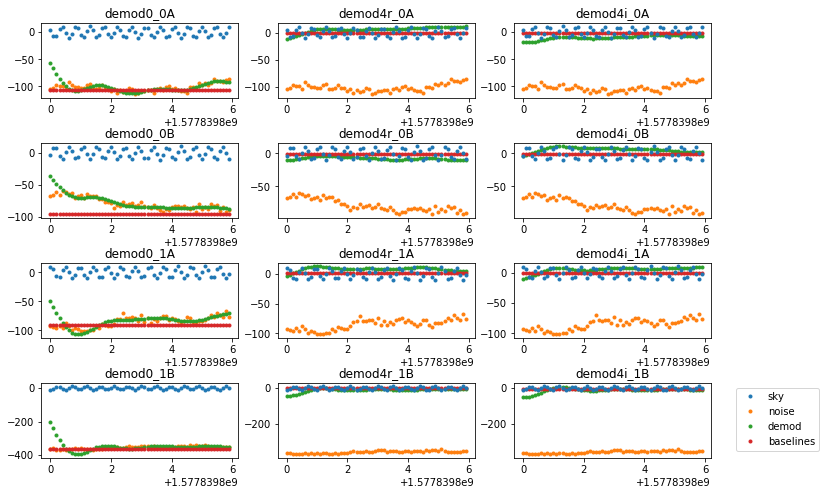

In [16]:
tod = data.obs[0]["tod"]
times = tod.local_times()

fig = plt.figure(figsize=[12, 8])
for idet, det in enumerate(tod.local_dets[:12]):
    sky = tod.local_signal(det.split('_')[-1], sky_name)
    full = tod.local_signal(det.split('_')[-1], copy_name)
    demodulated = tod.local_signal(det, full_name)
    destriped = tod.local_signal(det, destriped_name)

    ind = slice(0, 60)
    ax = fig.add_subplot(4, 3, 1 + idet)
    ax.set_title(det)
    ax.plot(times[ind], sky[ind], '.', label="sky", zorder=100)
    ax.plot(times[ind], full[ind] - sky[ind], '.', label="noise")
    ax.plot(times[ind], demodulated[ind], '.', label="demod")
    ax.plot(times[ind], demodulated[ind] - destriped[ind], '.', label="baselines")
ax.legend(bbox_to_anchor=(1.1, 1.00))
fig.subplots_adjust(hspace=0.6)


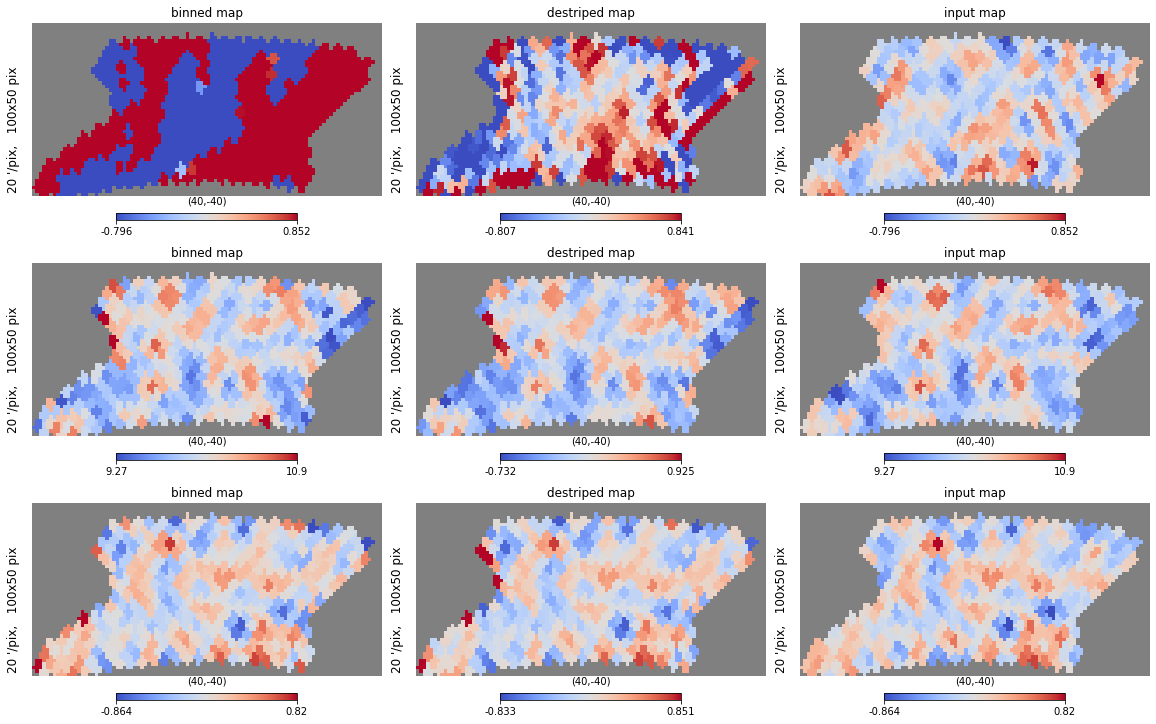

In [17]:
plt.figure(figsize=[16, 10])
hitmap = hp.read_map("maps/toast_test_hits.fits", verbose=False)
hitmap[hitmap == 0] = hp.UNSEEN
#hp.mollview(hitmap, sub=[3, 4, 1+3*IQU], title="hits")
inmap = hp.read_map("sim_map.fits", verbose=False, field=None) #sim_map #
inmap[:, hitmap == hp.UNSEEN] = hp.UNSEEN

binmap = hp.read_map("maps/toast_test_binned.fits", verbose=False, field=None)
binmap[:, binmap[0] == 0] = hp.UNSEEN

destriped = hp.read_map("maps/toast_test_destriped.fits", verbose=False, field=None)
destriped[:, destriped[0] == 0] = hp.UNSEEN
# Remove monopole
good = destriped[0] != hp.UNSEEN
destriped[:, good] -= np.median(destriped[:, good], axis=1).reshape(-1, 1)

for IQU in range(3):
    # Fix the plotting range for input signal and the destriped map
    vmin = inmap[IQU, hitmap != hp.UNSEEN].min()
    vmax = inmap[IQU, hitmap != hp.UNSEEN].max()
    vmean = inmap[IQU, hitmap != hp.UNSEEN].mean()

    #hp.mollview(binmap[IQU], sub=[3, 3, 1+3*IQU], title="binned map", cmap="coolwarm")
    hp.gnomview(binmap[IQU], rot=[40,-40],reso=20,xsize=100,ysize=50, sub=[3, 3, 1+3*IQU], title="binned map",
                cmap="coolwarm", min=vmin, max=vmax)

    #hp.mollview(destriped[IQU], sub=[3, 3, 2+3*IQU], title="destriped map", cmap="coolwarm")#, min=-amp, max=amp)
    hp.gnomview(destriped[IQU], rot=[40,-40],reso=20,xsize=100,ysize=50, sub=[3, 3, 2+3*IQU], title="destriped map",
                cmap="coolwarm", min=vmin - vmean, max=vmax - vmean)

    #hp.mollview(inmap[IQU], sub=[3, 3, 3+3*IQU], title="input map", cmap="coolwarm")#, min=-amp, max=amp)
    hp.gnomview(inmap[IQU], rot=[40,-40],reso=20,xsize=100,ysize=50, sub=[3, 3, 3+3*IQU], title="input map",
                cmap="coolwarm", min=vmin, max=vmax)
